# simulating quantum noise

## Introduction

In real life scenarios, quantum computers are imperfect and prone to noise. Some of the noise sources can be:
- **decoerence**, which corresponds to the loss of the quantum properties of the system, usually due to some interaction with the external environment;
- **thermal noise**, which affects in particular systems sensitive to temperature;
- **control errors**, due to some imperfections in the laboratory tools (cables, control boards, etc.);
- **cross-talk**, which happens when some operation we apply to a single qubit unintentionally affect the neighbouring qubits;
- **quantum state leakage**, which is the possibility to access some undesired energy level. It can happen for example using superconducting qubits, which are in principle N-levels systems prepared to isolate the first two energy levels.

More in general, a combination of these phenomena can affect a real quantum device, leading to a simple but relevant problem: the expected results are corrupted.

In `qibo`, we can simulate noisy systems and implement some strategies to take this problem into account, cleaning our results from undesired corruptions.

In the following:

1. we define a simple problem, consisting in calculating the expected value of a target observable over the final state we obtain executing a quantum circuit;
2. we compute the exact result with noiseless simulation;
3. we add noise to the circuit and compute the noisy result;

#### 1. Problem definition

We consider as an example a simple quantum system of three qubits, on which we aim to apply some rotations and then compute the expectation value of an observable composed of Pauli's.

In [ ]:
# Installation process for needed libraries
!pip install qibo
!pip install qibojit
!pip install git+https://github.com/qiboteam/qiboedu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.2/258.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.0/524.0 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Cloning https://github.com/qiboteam/qiboedu to /tmp/pip-req-build-e3zcinl2
  Running command git clone --filter=blob:none --quiet https://github.com/qiboteam/qiboedu /tmp/pip-req-build-e3zcinl2
  Resolved https://github.com/qiboteam/qiboedu to commit 6f8260ae2700b50abb7e9dc3958ced0a9e08a6ba
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━

In [ ]:
# importing needed modules
import numpy as np
import matplotlib.pyplot as plt

import qibo
from qibo import Circuit, gates, hamiltonians

from qiboedu.scripts import plotscripts

In [ ]:
# setting qibo's backend
qibo.set_backend(backend="numpy")

[Qibo 0.2.7|INFO|2024-04-11 16:15:05]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In [ ]:
# defining a parametric circuit with layered architecture
nqubits = 3
nlayers = 3

# We need to set density_matrix=True
c = Circuit(nqubits, density_matrix=True)
for l in range(nlayers):
  for q in range(nqubits):
    c.add(gates.RY(q=q, theta=0))
    c.add(gates.RZ(q=q, theta=0))
  for q in range(0, nqubits-1, 1):
    c.add(gates.CNOT(q0=q, q1=q+1))

c.add(gates.M(*range(nqubits)))

MeasurementResult(qubits=(0, 1, 2), nshots=0)

In [ ]:
print(c.draw())

q0: ─RY─RZ─o───RY─RZ─o───RY─RZ─o───M─
q1: ─RY─RZ─X─o─RY─RZ─X─o─RY─RZ─X─o─M─
q2: ─RY─RZ───X─RY─RZ───X─RY─RZ───X─M─


Now the circuit is set up and we can fix its action by injecting a specific list of rotational angles.

We get the numbers of contained parameters:

In [ ]:
print(c.summary())

nparams = len(c.get_parameters())
print(f"Number of parameters: {nparams}")

Circuit depth = 13
Total number of gates = 25
Number of qubits = 3
Most common gates:
ry: 9
rz: 9
cx: 6
measure: 1
Number of parameters: 18


And then we generate a well defined set of angles.

In [ ]:
# creating a new set of angles
angles = np.linspace(0, 2 * np.pi, nparams)
print(angles)

[0.         0.36959914 0.73919827 1.10879741 1.47839654 1.84799568
 2.21759481 2.58719395 2.95679309 3.32639222 3.69599136 4.06559049
 4.43518963 4.80478876 5.1743879  5.54398704 5.91358617 6.28318531]


In [ ]:
# setting the angles into the circuit
c.set_parameters(angles)
print(c.get_parameters())

[(0.0,), (0.36959913571644626,), (0.7391982714328925,), (1.1087974071493387,), (1.478396542865785,), (1.8479956785822313,), (2.2175948142986774,), (2.587193950015124,), (2.95679308573157,), (3.326392221448016,), (3.6959913571644627,), (4.065590492880909,), (4.435189628597355,), (4.804788764313801,), (5.174387900030248,), (5.543987035746694,), (5.91358617146314,), (6.283185307179586,)]


Now we have a quantum circuit composed of rotations and some CNOT gates. We want to use it to compute some calculations.

To do this, we can define an observable $\mathcal{O}$, for which we calculate:

$$ \langle \mathcal{O} \rangle \equiv \langle 0 | U^{\dagger}\, \mathcal{O}\, U | 0 \rangle \\. $$

We make the choice:

$$ \mathcal{O} = - \sum_{i=0}^N Z_i \\.$$

In [ ]:
# observable definition
obs = hamiltonians.Z(nqubits)
print(obs.matrix)

[[-3.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -1.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -1.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j  1.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -1.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j  1.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j  1.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j  3.-0.j]]


#### 2. Computing the exact expectation value

(0.04098-0j)|000><000| + (0.05215+0.09312j)|000><001| + (-0.00872-0.02801j)|000><010| + (-0.03659-0.10883j)|000><011| + (0.02184-0.00063j)|000><100| + (0.00065+0.0529j)|000><101| + (-0.03929+0.03608j)|000><110| + (-0.00399+0.0879j)|000><111| + (0.05215-0.09312j)|001><000| + (0.27797+0j)|001><001| + (-0.07475-0.01582j)|001><010| + (-0.29388-0.05533j)|001><011| + (0.02635-0.05043j)|001><100| + (0.12105+0.06585j)|001><101| + (0.032+0.1352j)|001><110| + (0.19468+0.12092j)|001><111| + (-0.00872+0.02801j)|010><000| + (-0.07475+0.01582j)|010><001| + (0.021-0j)|010><010| + (0.08218-0.00185j)|010><011| + ...
Counter({'011': 622, '001': 530, '111': 366, '101': 165, '110': 154, '000': 93, '010': 38, '100': 32})


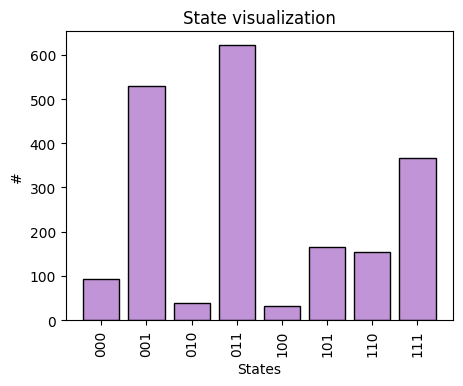

In [ ]:
# executing the circuit and collecting the frequencies
final_state = c(nshots=2000)
print(final_state)

frequencies = final_state.frequencies(binary=True)
print(frequencies)

plotscripts.visualize_states(frequencies)

Let's have a look also to the density matrix of this system.
We can use the function `plotscript.plot_density_matrix(state)`, which takes as argument the state object you get from a circuit execution `circuit().state()`. It is important to set the variable `density_matrix=True` when initializing the circuit.

The plot is going to show the absolute value of the amplitudes according to the density matrix 2D notation.

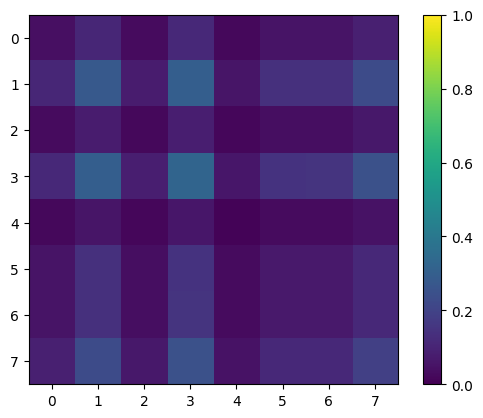

In [ ]:
# plot the density matrix using plotscripts.plot_density_matrix(state)
plt.imshow(np.abs(c().state()), vmin=0, vmax=1)
plt.colorbar()

As we can see from the plot, we have both diagonal and non diagonal components in the matrix.

The expectation value of this observable, which is diagonal in the computational basis can be computed directly from the frequencies.

Executing the system, we collect one frequency for each component of the state vector. We call $f_i$ the frequency corresponding to the $i-$th component of the state vector.

Now, considering an observable $\mathcal{O}$ whose eigenvalues are $\{o_i\}_{i=1}^{2^N}$, the expectation value of $\mathcal{O}$ given the set of frequencies $\{f_i\}_{i=1}^{2^N}$ is:

$$ E[\mathcal{O}] = \frac{1}{2^N} \sum_{i=1}^{2^N} o_i\, f_i. $$

In `Qibo`, this formula is implemented into a method of the `Hamiltonian` object:
`observable.expectation_from_samples(frequencies)`.

In [ ]:
# compute the expected value with expectation_from_samples
exp_value = obs.expectation_from_samples(frequencies)
print(exp_value)

0.5799999999999998


#### 3. Add noise to the system

Various different ways to simulate noise exist in `qibo`, but in this lecture we focus on one of them.

Let me introduce before the Pauli noise channel, which is used here to corrupt the circuit. If we consider a quantum state represented by the density matrix $\rho$, the effect of a Pauli noise channel on the state is

$$ \mathcal{E}(\rho) = \biggl(1 - \sum_{k=0}p_k\biggr)\rho + \sum_k p_k P_k \,\rho\, P_k \\,
$$

where $P_k$ is the $k$-th Pauli string and $p_k$ is the probability of applying $P_k$.

This channel allows to formalize a corruption of the state $\rho$ in which each Pauli represents some specific error which can occurr: for example, the Pauli X and Z respectively represent a bit-flip error and a phase-flip error in the qubit state.

We are going to use the `circuit.with_pauli_noise` method, which consists in applying a Pauli noise channel after every gate of the circuit.

In [ ]:
# defining Pauli's probabilities for each qubit of the system
noisy_map = {
    0: list(zip(["X", "Z"], [0.007, 0.008])),
    1: list(zip(["Y", "Z"], [0.01, 0.005])),
    2: list(zip(["X", "Z"], [0.008, 0.007]))
}

# use the circuit.with_pauli_noise
noisy_c = c.with_pauli_noise(noisy_map)

Let's print the new face of the circuit, with the Pauli noise channel after each gate.

In [ ]:
print(noisy_c.draw())
print('')
print(c.draw())

q0: ─RY─PN─RZ─PN─o─PN───RY─PN─RZ─PN────o─PN───RY─PN─RZ─PN────o─PN──────M─
q1: ─RY─PN─RZ─PN─X─PN─o─PN─RY─PN─RZ─PN─X─PN─o─PN─RY─PN─RZ─PN─X─PN─o─PN─M─
q2: ─RY─PN─RZ─PN──────X─PN─RY─PN─RZ─PN──────X─PN─RY─PN─RZ─PN──────X─PN─M─

q0: ─RY─RZ─o───RY─RZ─o───RY─RZ─o───M─
q1: ─RY─RZ─X─o─RY─RZ─X─o─RY─RZ─X─o─M─
q2: ─RY─RZ───X─RY─RZ───X─RY─RZ───X─M─


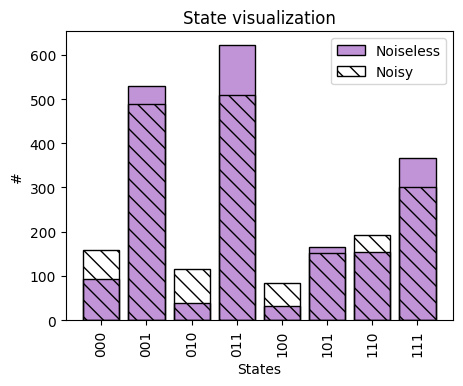

In [ ]:
# execute the circuit and visualize frequencies
noisy_final_state = noisy_c(nshots=2000)

noisy_frequencies = noisy_final_state.frequencies(binary=True)
plotscripts.visualize_states(frequencies, noisy_frequencies)

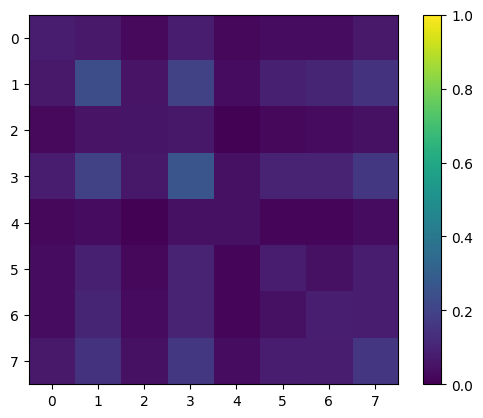

In [ ]:
# plot the density matrix using plotscripts.plot_density_matrix(state)
plt.imshow(np.abs(noisy_c().state()), vmin=0, vmax=1)
plt.colorbar()

From the matrix, we can see the off diagonal terms are vanishing.







As final step of this lecture 4, let's compute the expectation value of $\mathcal{O}$ over the noisy final state.

In [ ]:
# compare the expectation values with and without noise
noisy_exp = obs.expectation_from_samples(noisy_frequencies)

print(f"Noiseless expectation value: {exp_value}")
print(f"Noisy expectation value: {noisy_exp}")

Noiseless expectation value: 0.5799999999999998
Noisy expectation value: 0.29799999999999993


Exercise: what is happening to the system? why is the expected value of $Z$ decreasing? What happens if you increase the magnitude of the noise?

# mitigating the noise

## Introduction

In lecture 4 we have learnt how to simulate a noisy system using Pauli noise channels.

We typically approach a noisy system in two different ways:

1. **quantum error correction (QEC)**, which involves a series of techniques which aim to detect and remove actively the noise from a bench of qubits of a quantum system. It needs a large number of physical qubits to actually correct and protect the state of a restricted number of them. Thanks to QEC the noise is practically removed (or corrected) from some qubits of a system.
2. **quantum error mitigation (QEM)** consists in a collection of algorithms used to learn a noise map, which is then used to mitigate the noisy results. These methods doesn't correct the noise, but can be seen as post-processing techniques to extract an estimation of the noiseless results on top of the knowledge we have of the system.

In this lecture we are going to focus on a specific QEM technique: the Clifford Data Regression (CDR).

In [ ]:
from qibo.models import error_mitigation
from qibo.noise import PauliError, NoiseModel

#### Clifford Data Regression

##### The target circuit

The idea behind the CDR is very simple and effective: we consider a target circuit $U$, which we aim to execute in order to compute some expectation value
$$ \langle \mathcal{O} \rangle^U \equiv \langle 0 | U^{\dagger}\, \mathcal{O}\, U | 0 \rangle \\. $$
We are going to inherit the same problem of the lecture 4:

In [ ]:
# problem definition
# use the same circuit and the same problem
nqubits = 3
nlayers = 3

c = Circuit(nqubits, density_matrix=True)
for l in range(nlayers):
  for q in range(nqubits):
    c.add(gates.RY(q=q, theta=0))
    c.add(gates.RZ(q=q, theta=0))
  for q in range(0, nqubits-1, 1):
    c.add(gates.CNOT(q0=q, q1=q+1))
c.add(gates.M(*range(nqubits)))

# setting the angles
nparams = len(c.get_parameters())
angles = np.linspace(0, 2*np.pi, nparams)

# settings angles into the circuit
c.set_parameters(angles)

print(c.draw())

# observable definition
obs = hamiltonians.Z(nqubits)


q0: ─RY─RZ─o───RY─RZ─o───RY─RZ─o───M─
q1: ─RY─RZ─X─o─RY─RZ─X─o─RY─RZ─X─o─M─
q2: ─RY─RZ───X─RY─RZ───X─RY─RZ───X─M─


##### A training set of semi-Clifford circuits
Once the problem is set up, we collect a set of circuits $\{C^i\}$, which have the same dimension of $U$, but they are mostly composed of Clifford gates. The idea is to create a set of circuits whose shape is similar to our target, but they are fastly simulable on a classical computer.

We are going to use the already implemented CDR we have in `qibo`, in which the circuits $C^i$ are generated using the following function


In [36]:
# generate one circuit according with CDR
cdr_circuit = error_mitigation.sample_training_circuit_cdr(c)

which changes some of the non-Clifford gates of the circuit with Clifford ones. In this particular case, some of the $RZ$ gates, which are non-Clifford if filled with general angles, are "cliffordized" by replacing the angles with multiples of $\pi/2$.

In [40]:
# compare circuit shapes and angles after CDR sample
print(c.draw(), "\n\n")
print(cdr_circuit.draw(), "\n\n")

print(c.get_parameters())
print(cdr_circuit.get_parameters())

q0: ─RY─RZ─o─────X─RY─RZ─o─────X─M─
q1: ─RY─RZ─X─o───|─RY─RZ─X─o───|─M─
q2: ─RY─RZ───X─o─|─RY─RZ───X─o─|─M─
q3: ─RY─RZ─────X─o─RY─RZ─────X─o─M─ 


q0: ─RY─RZ─o─────X─RY─RZ─o─────X─M─
q1: ─RY─RZ─X─o───|─RY─RZ─X─o───|─M─
q2: ─RY─RZ───X─o─|─RY─RZ───X─o─|─M─
q3: ─RY─RZ─────X─o─RY─RZ─────X─o─M─ 


[(-0.003153590446979702,), (0.32217959826280956,), (3.138582238801533,), (3.3695704755591165,), (-0.20376007812253105,), (5.6945808242927126e-05,), (0.11338029789129538,), (-0.003827811620867244,), (-1.8330814395842134,), (0.004061569521451675,), (-1.5706831961281191,), (-5.62852104465501e-05,), (1.8343089451995345,), (-3.1386719268065444,), (-1.835782552122486,), (-0.00018742989066027472,)]
[(-0.003153590446979702,), (0.32217959826280956,), (3.138582238801533,), (3.141592653589793,), (-0.20376007812253105,), (0.0,), (0.11338029789129538,), (0.0,), (-1.8330814395842134,), (0.0,), (-1.5706831961281191,), (-5.62852104465501e-05,), (1.8343089451995345,), (-3.1386719268065444,), (-1.835782552122486,),

##### The noise map $\ell$

At this point, we compute both noisy $ \{ \langle \mathcal{O} \rangle^i_{\rm noisy} \}$ and noiseless  $\{\langle \mathcal{O} \rangle^i \}$ expectation values executing the circuits $\{C^i\}$ on a noisy device and on a classical exact simulator.

We then fit the scatterplot $\langle \mathcal{O} \rangle_{\rm noisy}$ vs.  $\langle \mathcal{O} \rangle$ with some map $\ell$.

For doing this, we use the `error_mitigation.CDR` method.
The method requires a noise model to be defined if we are simulating. In order to reproduce the same noise of lecture 4, we build the following noise model:

In [ ]:
# build the noise model using NoiseModel
noise = NoiseModel()

noise.add(PauliError([("X", 0.007), ("Z", 0.008)]), qubits=0)
noise.add(PauliError([("Y", 0.01), ("Z", 0.005)]), qubits=1)
noise.add(PauliError([("X", 0.008), ("Z", 0.007)]), qubits=2)


Now we are ready to call the mitigation method.

In [ ]:
# execute CDR
mit_exp, noisy_exp, fit_params, training_data = error_mitigation.CDR(
    circuit = c,
    observable = obs,
    noise_model = noise,
    nshots = 50000,
    n_training_samples = 50,
    full_output = True
)

By setting `full_output=True` we are saving many information about the QEM method:
1. the mitigated expectation value;
2. the noisy expectation value;
3. the fitted parameters according to the chosen map form $\ell$;
4. the whole set of $\langle \mathcal{O} \rangle_{\rm noisy}$ and $\langle \mathcal{O} \rangle$ collected using the training circuits $C^i$.

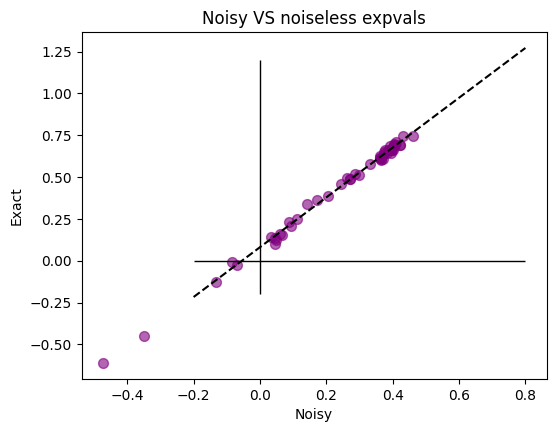

In [ ]:
# plot results
x = np.linspace(-0.2, 0.8, 100)
y = fit_params[0] * x + fit_params[1]

plt.figure(figsize=(6, 6*6/8))
plt.title("Noisy VS noiseless expvals")
plt.xlabel("Noisy")
plt.ylabel("Exact")
plt.plot(x, y, color="black", ls="--", label="CDR fit")

plt.scatter(training_data["noisy"], training_data["noise-free"], color="purple", alpha=0.6, s=50, label="Training circuit")

plt.vlines(0, -0.2, 1.2, color="black", ls="-", lw=1)
plt.hlines(0, -0.2, 0.8, color="black", ls="-", lw=1)

plt.show()

And, thanks to the CDR, we get a cleaner expectation value

In [ ]:
# compare expectaion values
print(f"Noisy expval: {noisy_exp}")
print(f"Mitigated expval: {mit_exp}")
print(f"Exact expval: {0.619}")


Noisy expval: 0.3362
Mitigated expval: 0.5813610028425599
Exact expval: 0.619


Which is closer to the exact one with respect to the noisy result!

## Ground state approximation via VQE
Quantum Machine Learning

In [ ]:
from qibo import optimizers
from qiboedu.scripts.plotscripts import plot_vqe_states

#### Problem setup: $H_{\rm target}$ and circuit $U(\theta)$

The goal of a VQE is to train a parametric quantum circuit to approximate the ground state of a target hamiltonian $H_{\rm target}.$
To this purpose, we need to define a target hamiltonian and a parametric circuit $U(\theta)$.

In [ ]:
# defining hamiltonian
def build_hamiltonian(nqubits, h):
  """ Build TFIM hamiltonian """
  return hamiltonians.TFIM(nqubits, h)

In [ ]:
#defining VQE function
def build_vqe_circuit(nqubits, nlayers):
  """ Build VQE circuit """
  c = Circuit(nqubits)
  for l in range(nlayers):
    for q in range(nqubits):
      c.add(gates.RY(q=q, theta=0))
      c.add(gates.RZ(q=q, theta=0))

    for q in range(0, nqubits-1, 1):
      c.add(gates.CNOT(q0=q, q1=q+1))
    c.add(gates.CNOT(q0=nqubits-1, q1=0))
  c.add(gates.M(*range(nqubits)))
  return c

#### Loss function definition

The loss function $J$ is the expectation value of the target hamiltonian over the final state one gets if executes the quantum circuit $U$:
$$ J = \langle 0 | U^{\dagger}(\theta) H_{\rm target} U(\theta) | 0 \rangle. $$
In this setup, we are searching for an optimal set of parameters $\theta$ such that the final state $| \psi \rangle = U(\theta)|0\rangle$ approximates the ground state of $H_{\rm target}.$

In [ ]:
# defining loss function
def loss_function(parameters, circuit, hamiltonian):
  """ Compute the expval of hamiltonian """
  circuit.set_parameters(parameters)
  final_state = circuit().state()
  return hamiltonian.expectation(final_state)

#### Execution

In [ ]:
# setting the circuit architecture
nqubits = 4
nlayers = 2

c = build_vqe_circuit(nqubits, nlayers)
print(c.draw())

q0: ─RY─RZ─o─────X─RY─RZ─o─────X─M─
q1: ─RY─RZ─X─o───|─RY─RZ─X─o───|─M─
q2: ─RY─RZ───X─o─|─RY─RZ───X─o─|─M─
q3: ─RY─RZ─────X─o─RY─RZ─────X─o─M─


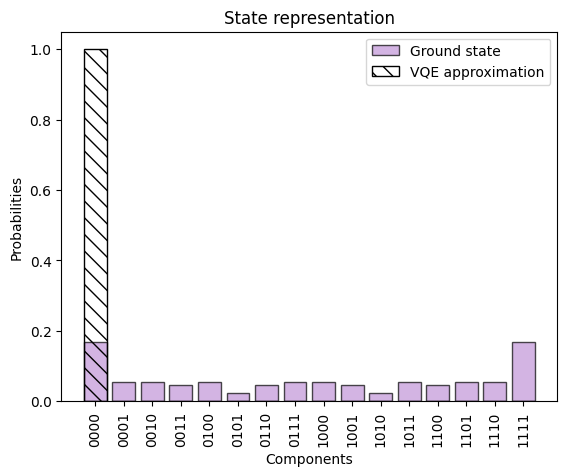

In [ ]:
# build hamiltonian and collect ground state
h = build_hamiltonian(nqubits, h=2)
ground_state = h.ground_state()

# plotting ground state VS VQE's state
plot_vqe_states(ground_state, c().state())

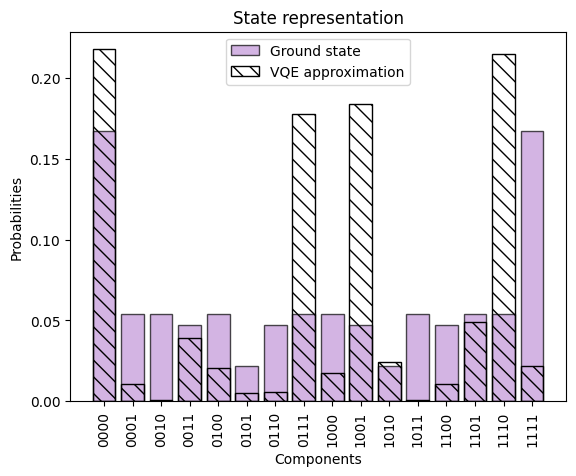

In [ ]:
# set initial parameters
np.random.seed(42)
nparams = len(c.get_parameters())
initial_parameters = np.random.randn(nparams)

# final state after execution with random parameters
c.set_parameters(initial_parameters)

plot_vqe_states(ground_state, c().state())

In [ ]:
# optimize and collect optimization results
result = optimizers.optimize(
    loss = loss_function,
    initial_parameters=initial_parameters,
    args = (c, h),
    method = "Powell"
)

print(result)

(-8.501799034226465, array([-3.15359045e-03,  3.22179598e-01,  3.13858224e+00,  3.36957048e+00,
       -2.03760078e-01,  5.69458082e-05,  1.13380298e-01, -3.82781162e-03,
       -1.83308144e+00,  4.06156952e-03, -1.57068320e+00, -5.62852104e-05,
        1.83430895e+00, -3.13867193e+00, -1.83578255e+00, -1.87429891e-04]),  message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -8.501799034226465
       x: [-3.154e-03  3.222e-01 ... -1.836e+00 -1.874e-04]
     nit: 10
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 5.955e-03  1.945e-01 ... -8.345e-04 -3.155e-04]]
    nfev: 1436)


In [ ]:
# best parameters
best_p = result[1]

print(best_p)

[-3.15359045e-03  3.22179598e-01  3.13858224e+00  3.36957048e+00
 -2.03760078e-01  5.69458082e-05  1.13380298e-01 -3.82781162e-03
 -1.83308144e+00  4.06156952e-03 -1.57068320e+00 -5.62852104e-05
  1.83430895e+00 -3.13867193e+00 -1.83578255e+00 -1.87429891e-04]


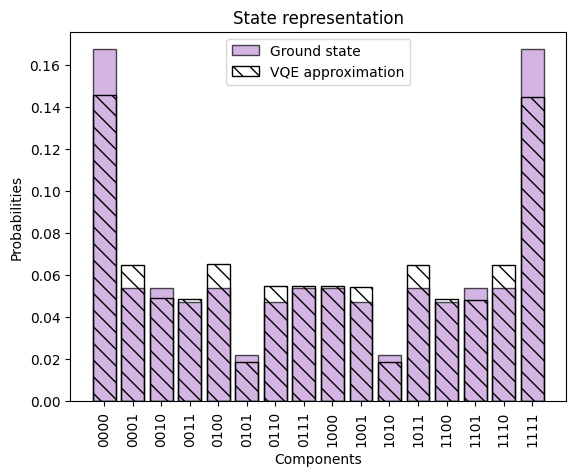

In [ ]:
# setting the best parameters into the circuit
c.set_parameters(best_p)

# plotting ground state VS VQE's state
plot_vqe_states(ground_state, c().state())